In [1]:
import numpy as np
import os
import contextlib
import pickle
import tqdm
from datasets.XP2 import Xp2Dataset
from datasets.utils import plot_on_topomap, select_grid_results_by_metric, plot_channel_coefficients
import matplotlib.pyplot as plt
from datasets.mh_features import get_distance_matrix, correlation_distance
from models.efp import mh_grid_search, mh_common_model
from models.clustering import get_trained_model_on_cluster
import pandas as pd

import seaborn as sns

/home/riccardo/Projects/EEG-fMRI_fusion/models/clustering.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
#TODO Handle -bad- annotations if there are any
# root = '/home/cat/PycharmProjects/EEG-fMRI_fusion/data/XP2_derivatives_sample/'
base_folder = '/home/riccardo/MHdatasets'
stockwell_folder = '/media/storage1/stockwells'
out_folder = '/home/riccardo/MHdatasets/saves'
roi_str =  'm1'
window_type='kazemi'
gamma=15
fmax = 60
n_bands = 10
workers = 15

# base_folder = '/home/cat/Documents/'
root = os.path.join(base_folder,'XP2')
# dataset = Xp2Dataset(root, 'dataset.p')
# dataset = Xp2Dataset(root, os.path.join(base_folder,'dataset_MH_linux.p'))
dataset = Xp2Dataset(root, os.path.join(base_folder, f'dataset_MH_i{fmax}_{n_bands}_{window_type}_{gamma}.p'))
dataset.get_eeg_data(False)
dataset.get_mh_features_and_targets(nf_key_bold=('roimean', 'bgmean'), 
                                    fmax=fmax,
                                    n_bands=n_bands,
                                    overwrite=False,
                                    workers=workers,
                                    band_boundaries=None,
                                    save_folder=stockwell_folder,
                                    base_freq_grid_size=500,
                                    gamma=gamma,
                                    window_type=window_type, # kazemi, gauss
                                   )

Starting workers and distributing tasks...


Preparing features and targets...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 1077.34it/s]


In [3]:
dataset_unibands = Xp2Dataset(root, os.path.join(base_folder, f'dataset_MH_uniband_a{fmax}_{n_bands}_{window_type}_{gamma}.p'))
dataset_unibands.get_eeg_data(False)
shared_bands = dataset_unibands.get_dataset_shared_bands(fmax=fmax)
dataset_unibands.get_mh_features_and_targets(nf_key_bold=('roimean', 'bgmean'), 
                                    fmax=fmax,
                                    n_bands=n_bands,
                                    overwrite=False,
                                    workers=workers,
                                    band_boundaries=shared_bands,
                                    save_folder=stockwell_folder,
                                    base_freq_grid_size=500,
                                    gamma=gamma,
                                    window_type=window_type, # kazemi, gauss
                                            )

Effective window size : 10.240 (s)
Starting workers and distributing tasks...


Preparing features and targets...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 1098.97it/s]


In [4]:
delay_time_seconds = 12 # 17.25
target_str = f'target_{roi_str}'
default_subject=1
subject=default_subject
test_ratio=.2
regularization_grid_search=50
overwrite=True

In [5]:
all_grid_search_results_unibands, all_models_unibands, grouped_unibands = mh_grid_search(
    dataset_unibands, f'{out_folder}/all_grid_search_results_a{roi_str}_{fmax}_{n_bands}_{window_type}_{gamma}_samebands.p',
    f'{out_folder}/all_models_a{roi_str}_{fmax}_{n_bands}_{window_type}_{gamma}_samebands.p',
    target_str=target_str,
    test_ratio=test_ratio,
    delay_time_seconds=delay_time_seconds,
)

all_grid_search_results, all_models, grouped = mh_grid_search(
    dataset, f'{out_folder}/all_grid_search_results_a{roi_str}_{fmax}_{n_bands}_{window_type}_{gamma}.p',
    f'{out_folder}/all_models_a{roi_str}_{fmax}_{n_bands}_{window_type}_{gamma}.p',
    target_str=target_str,
    test_ratio=test_ratio,
    delay_time_seconds=delay_time_seconds,
)

Using order based on dataframe channel info
Using order based on dataframe channel info
Subjects:
[np.int64(3), np.int64(4), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(20), np.int64(21), np.int64(37), np.int64(42), np.int64(43)]
len: 11, 25.0% of the total.
Max mean correlation channel: CP1
Using order based on dataframe channel info
Subjects:
[np.int64(3), np.int64(4), np.int64(7), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(20), np.int64(21), np.int64(22), np.int64(42)]
len: 11, 25.0% of the total.
Max mean correlation channel: C1
Using order based on dataframe channel info


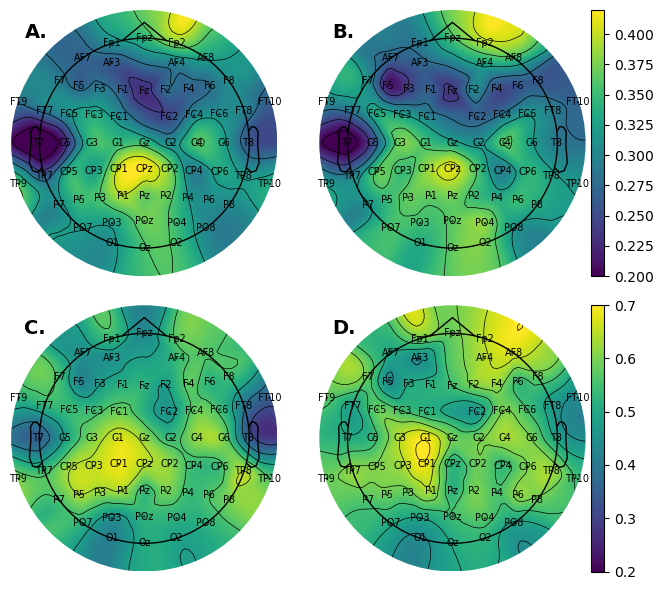

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(7, 6))
vlim1=(.2, .42)
vlim2=(.2, .7)
grouped_corr = all_grid_search_results_unibands.groupby('channel').mean()

plot_on_topomap(grouped_corr['pearson r test'], dataset[0], axes=axes[0,0], vlim=vlim1, plot_bar=False)
axes[0, 0].text(0.05, 0.95, 'A.', transform=axes[0, 0].transAxes,
                             fontsize=14, fontweight='bold', va='top', ha='left')

grouped_corr = all_grid_search_results.groupby('channel').mean()
plot_on_topomap(grouped_corr['pearson r test'], dataset[0], axes=axes[0,1], vlim=vlim1)
axes[0, 1].text(0.05, 0.95, 'B.', transform=axes[0, 1].transAxes,
                             fontsize=14, fontweight='bold', va='top', ha='left')


_= select_grid_results_by_metric(all_grid_search_results_unibands,
                                 dataset_unibands, corr_cutoff = 0.533, selection_metric = 'pearson val', axes=axes[1,0],
                                 vlim=vlim2, plot_bar=False)
axes[1, 0].text(0.05, 0.95, 'C.', transform=axes[1, 0].transAxes,
                             fontsize=14, fontweight='bold', va='top', ha='left')

_= select_grid_results_by_metric(all_grid_search_results,
                                 dataset, corr_cutoff = 0.525, selection_metric = 'pearson val', axes=axes[1,1], plot_bar=True,
                                 vlim=vlim2)
axes[1, 1].text(0.05, 0.95, 'D.', transform=axes[1, 1].transAxes,
                             fontsize=14, fontweight='bold', va='top', ha='left')

plt.tight_layout()
plt.show()

In [7]:
# CPz: from unibands, all, and individual, all
# C1 from individual, thresholded
# CP1 from unibands, thresholded

interesting_electrodes = ['CP1', 'C1', 'CPz']

## Results without any clustering

In [8]:
savefile = f'{out_folder}/full_dataset_models_a{roi_str}_{fmax}_{n_bands}_{window_type}_{gamma}.p'
if not os.path.exists(savefile):
    everything_results = {}
else:
    everything_results = pickle.load(open(savefile, 'rb'))
    
accepted_indexes = []
for s, subj in enumerate(dataset_unibands.dataset):
    if subj['mh_features'].shape[-1] == subj[target_str].shape[-1]:
        accepted_indexes.append(s)
valid_samples = dataset_unibands.get_subsample(accepted_indexes)

for channel in interesting_electrodes:
    if channel not in everything_results:
        common_model_results, _ = mh_common_model(valid_samples, None, channel, target_str)
        everything_results[channel] = common_model_results
pickle.dump(everything_results, open(savefile, 'wb'))


full_dataset_results = []
for electrode, res in everything_results.items():
    for r in res:
        r['electrode'] = electrode
    full_dataset_results.extend(res)
full_dataset_results = pd.DataFrame(full_dataset_results)
full_dataset_results

,pearson r test,pearson p test,MSE test,nMSE test,r2 test,MSE val,r2 val,pearson val,electrode
0,0.383477,1.939374e-44,0.896527,0.891679,0.113142,0.968029,0.033405,0.206314,CP1
1,0.320194,9.067532e-31,0.840935,0.876177,0.087104,0.970376,0.031239,0.201929,CP1
2,0.177818,3.274089e-10,0.971981,0.970889,0.030201,0.965280,0.035312,0.210938,CP1
3,-0.085525,2.661430e-03,1.090687,1.093353,-0.096025,0.963182,0.035933,0.212800,CP1
4,0.063080,2.682497e-02,1.014444,1.020580,-0.026753,0.962280,0.037262,0.215077,CP1
...,...,...,...,...,...,...,...,...,...
118,0.434838,5.459771e-58,0.822113,0.828158,0.165753,0.949442,0.050269,0.241368,CPz
119,0.426543,1.226279e-55,0.857766,0.848181,0.161297,0.949762,0.050346,0.241327,CPz
120,0.225921,1.009388e-15,0.958313,0.958691,0.040932,0.945644,0.052014,0.244369,CPz
121,0.292277,1.089022e-25,0.948019,0.931764,0.084212,0.945644,0.052014,0.244369,CPz


In [9]:
full_dataset_results[full_dataset_results['electrode'] == 'C1']['pearson r test'].mean()

np.float64(0.196277027023368)

In [10]:
accepted_indexes = []
for s, subj in enumerate(dataset_unibands.dataset):
    if subj['mh_features'].shape[-1] == subj[target_str].shape[-1]:
        accepted_indexes.append(s)
valid_samples = dataset_unibands.get_subsample(accepted_indexes)

common_model_results, general_model_cpz = mh_common_model(valid_samples, None, 'CPz', target_str, train_only=True)
_, general_model_c1 = mh_common_model(valid_samples, None, 'C1', target_str, train_only=True)

Performing LOO:   0%|                                                                                                                                                                                                                                | 0/41 [00:00<?, ?it/s]


Skipped
Training final model.


Performing LOO:   0%|                                                                                                                                                                                                                                | 0/41 [00:00<?, ?it/s]


Skipped
Training final model.


In [11]:
full_dataset_results.to_pickle('M1_bars.pickle')

0.196277027023368


Text(0.5, 0, 'Channel')

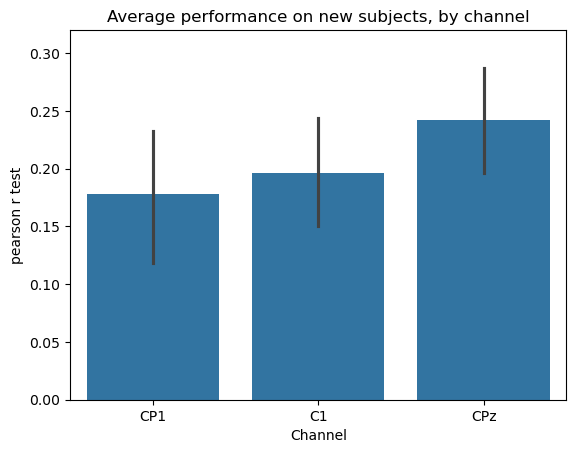

In [12]:
c1_reference = full_dataset_results[full_dataset_results['electrode'] == 'C1']['pearson r test'].mean()
print(c1_reference)
sns.barplot(data=full_dataset_results[full_dataset_results['electrode'] != 'Fp2'], x='electrode', y='pearson r test')
plt.ylim((0,0.32))
plt.title('Average performance on new subjects, by channel')
plt.xlabel('Channel')

In [13]:
full_dataset_results.groupby('electrode')['pearson r test'].mean()

electrode
C1     0.196277
CP1    0.178276
CPz    0.242131
Name: pearson r test, dtype: float64

In [14]:
cpz_general_results = np.array(full_dataset_results[full_dataset_results['electrode'] == 'CPz']['pearson r test'])

In [15]:
cpz_general_results

array([ 0.37355207,  0.19624364,  0.20893306,  0.15577406,  0.2586405 ,
        0.12199021,  0.14581625,  0.22731124, -0.13973722, -0.12653729,
        0.05857361,  0.49256138,  0.58520334,  0.4223506 ,  0.29984463,
        0.18658854,  0.29812541,  0.38398006,  0.11053517,  0.39028572,
        0.20950308,  0.26124744,  0.17988175,  0.1953808 ,  0.18415012,
       -0.00323454,  0.33353333,  0.29803567,  0.32678779,  0.25965965,
        0.02515667,  0.08683945,  0.24714755,  0.33687384,  0.33359689,
        0.316692  ,  0.4348381 ,  0.42654299,  0.22592053,  0.29227706,
        0.30649142])

In [16]:
cpz_general_results.mean()

np.float64(0.2421306485075325)

In [17]:
to_save = full_dataset_results[full_dataset_results['electrode'] != 'Fp2']
to_save['Target'] = ['M1'] * len(to_save)
to_save.to_csv('clustering_m1_general.csv', index=False)

## Clustering

In [18]:
for run in dataset.dataset:
    if type(run['mh_band_boundaries']) is list:
        run['mh_band_boundaries'] = run['mh_band_boundaries'][0]
for run in dataset_unibands.dataset:
    if type(run['mh_band_boundaries']) is list:
        run['mh_band_boundaries'] = run['mh_band_boundaries'][0]

In [32]:
savefile = f'{out_folder}/clustering_data_a{roi_str}_{fmax}_{n_bands}_{window_type}_{gamma}.p'
from scipy.spatial.distance import euclidean, cityblock, cosine, canberra

distances_for_clustering = {
    'l1': cityblock,
    'cosine': cosine,
    'l2': euclidean,
    'canberra': canberra,
    'pearson': correlation_distance,
                           }
if os.path.exists(savefile):
    data_for_clustering = pickle.load(open(savefile, 'rb'))
    _, subjects, _ = get_distance_matrix(dataset, all_models, 'C1', shared_bands)

else:
    data_for_clustering = {
        'interpolation': [],
        'channel': [],
        'distance': [],
        'band sharing': [],
        'precomputed': [],
        'data': [],
    }
    
for interpolation in ['mh', 'interp']:
    for channel in interesting_electrodes:
        for band_sharing in [True, False, 'from start']:
            tdf = pd.DataFrame(data_for_clustering)
            tdf_sel = tdf[
            (tdf['channel'] == channel) &
            (tdf['interpolation'] == interpolation) &
            (tdf['band sharing'] == band_sharing)
            ]
            if len(tdf_sel)>0: continue
                
            data_to_use = dataset_unibands if band_sharing=='from start' else dataset
            models = all_models_unibands if band_sharing=='from start' else all_models
            if band_sharing:
                bands = shared_bands
                shared_channel_names = dataset_unibands[0]['mh_band_boundaries']
            else:
                bands = None
                shared_channel_names = None
            results = get_distance_matrix(
                data_to_use, models, channel, bands, method=interpolation, 
                distance_metric=list(distances_for_clustering.values()),
                fmax=fmax, shared_channel_names = shared_channel_names
            )
            matrices = results[0]

            for distance, matrix in zip(distances_for_clustering.keys(), matrices):
            
                data_for_clustering['interpolation'].append(interpolation)
                data_for_clustering['channel'].append(channel)
                data_for_clustering['distance'].append(distance)
                data_for_clustering['band sharing'].append(band_sharing)
                data_for_clustering['precomputed'].append(True)
                data_for_clustering['data'].append(matrix)
            
            subjects = results[1]
pickle.dump(data_for_clustering, open(savefile, 'wb'))

from datasets.mh_features import get_corr_matrix_distances
from scipy.linalg import logm

def frobenius_dist(a, b):
    return np.linalg.norm(a - b, ord='fro')

for chhh in ['C1', 'CP1', 'CPz']:
    method = 'covariance'
    computed_distances = get_corr_matrix_distances(dataset, all_models,
                                                   distance_metric=lambda a,b: frobenius_dist(logm(a), logm(b)),
                                                   selected_channels=(
                                                       'CP3', 'CP1', 'CPz', 'CP5', 'P5', 'P3', 'P1', 'C3', 'C1', 'Cz',
                                                       'CP2',
                                                   ),
                                                       matrix_type=method,
                                                  )[0]

    data_for_clustering['interpolation'].append('Matrices')
    data_for_clustering['channel'].append(chhh)
    data_for_clustering['distance'].append('Log-Euclidean')
    data_for_clustering['band sharing'].append(method)
    data_for_clustering['precomputed'].append(True)
    data_for_clustering['data'].append(computed_distances)

data_for_clustering = pd.DataFrame(data_for_clustering)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 48.98it/s]


In [20]:
linkages = ['average']
data_source = data_for_clustering[
    (data_for_clustering['channel'] == 'C1') &
    (data_for_clustering['interpolation'] == 'mh') &
    (data_for_clustering['band sharing'] == True) &
    (data_for_clustering['distance'] == 'canberra')
].iloc[0]
    
            
channel = data_source['channel']
interpolation = data_source['interpolation'] # mh or interp
distance_for_precomputed = data_source['distance']
band_sharing = data_source['band sharing']
precomputed = data_source['precomputed']
data = data_source['data']
metric = 'precomputed'
            
for linkage in linkages:
    if band_sharing == 'from start':
        r = get_trained_model_on_cluster(data, dataset_unibands, linkage, metric, band_sharing, subjects, channel,
                                        stockwell_save_folder=stockwell_folder,fmax=fmax, target_str=target_str,
                                        )
    else:
        r = get_trained_model_on_cluster(data, dataset, linkage, metric, band_sharing, subjects, channel,
                                        stockwell_save_folder=stockwell_folder,fmax=fmax, target_str=target_str,
                                        )
    common_model_results, estimator, wcss, n_clusters, n_to_select, selected_dataset_indices, max_min_distance = r


Effective window size : 10.240 (s)
Starting workers and distributing tasks...
Reading 0 ... 63999  =      0.000 ...   319.995 secs...
Reading 0 ... 63999  =      0.000 ...   319.995 secs...
Reading 0 ... 63999  =      0.000 ...   319.995 secs...
Reading 0 ... 63999  =      0.000 ...   319.995 secs...
Reading 0 ... 63999  =      0.000 ...   319.995 secs...
Reading 0 ... 63999  =      0.000 ...   319.995 secs...
Reading 0 ... 63999  =      0.000 ...   319.995 secs...
Reading 0 ... 63999  =      0.000 ...   319.995 secs...
Reading 0 ... 63999  =      0.000 ...   319.995 secs...
Reading 0 ... 63999  =      0.000 ...   319.995 secs...


Performing LOO: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:27<00:00,  8.73s/it]


Training final model.


In [21]:
# import joblib
# cluster_model_c1 = estimator
# joblib.dump(estimator.best_estimator_, 'regressor.pkl')

In [22]:
included_subjects_all = list(all_models_unibands.keys())

Text(50.722222222222214, 0.5, 'Frequency band')

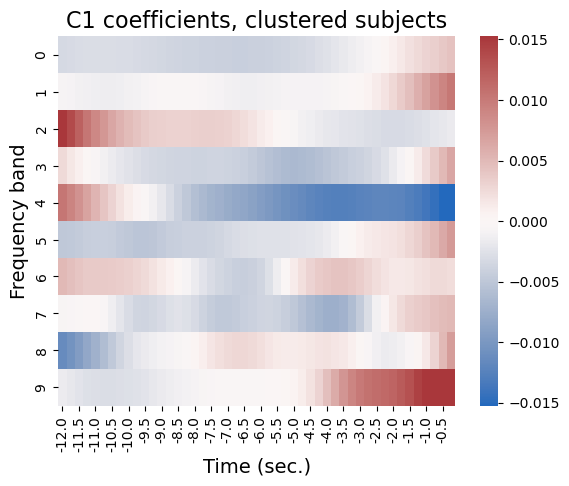

In [23]:
#from electrode selection, in-cluster average parameters
plt.rcParams.update({
    'axes.titlesize': 16,    # Title
    'axes.labelsize': 14,    # Axis labels
#     'xtick.labelsize': 12,   # X-axis ticks
#     'ytick.labelsize': 12,   # Y-axis ticks
#     'legend.fontsize': 12    # Legend
})
plot_channel_coefficients(selected_dataset_indices, dataset, 'C1', estimator.best_estimator_, plotting_std_range=3)
plt.title('C1 coefficients, clustered subjects')
plt.xlabel('Time (sec.)')
plt.ylabel('Frequency band')

In [24]:
ravel_models = sum([k for k in all_models.values()], [])

In [25]:
standardized_means = [k.coef_.mean() / k.coef_.std() for k in ravel_models]

In [26]:
np.mean(np.abs(standardized_means))

np.float64(0.34847377153009385)

Text(50.722222222222214, 0.5, 'Frequency band')

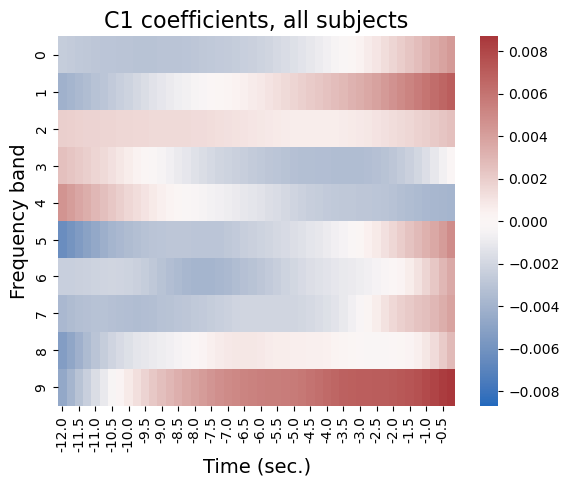

In [27]:
#from electrode selection, averaging models
plot_channel_coefficients(None, dataset, 'C1', general_model_c1.best_estimator_, plotting_std_range=3)
plt.title('C1 coefficients, all subjects')
plt.xlabel('Time (sec.)')
plt.ylabel('Frequency band')

Text(0.5, 1.0, 'CPz coefficients')

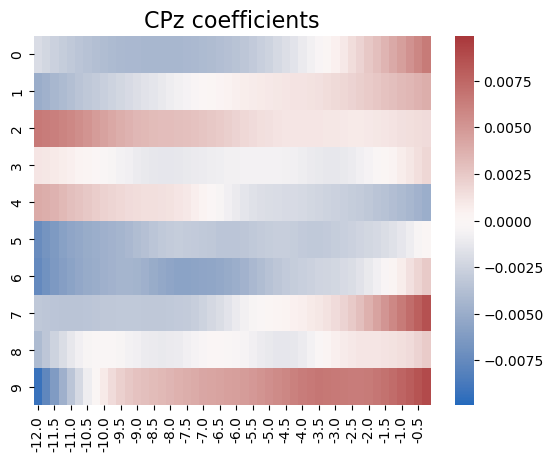

In [28]:
#from electrode selection, averaging models
plot_channel_coefficients(None, dataset, 'CPz', general_model_cpz.best_estimator_, plotting_std_range=3)
plt.title('CPz coefficients')

In [31]:
savefile = f'{out_folder}/clustering_search_corr_a{roi_str}_{fmax}_{n_bands}_{window_type}_{gamma}.p'
if os.path.exists(savefile):
    grid_search_clustering_coll = pickle.load(open(savefile, 'rb'))
else:
    grid_search_clustering_coll = []

linkages = ['average', 'complete', 'single']
for data_index in tqdm.autonotebook.tqdm(range(len(grid_search_clustering_coll), len(data_for_clustering))):
    data_source = data_for_clustering.iloc[data_index]
    with open(os.devnull, 'w') as fnull:
        with contextlib.redirect_stdout(fnull), contextlib.redirect_stderr(fnull):
            grid_search_clustering_parameters = {
                                                'linkage': [],
                                                'metric': [],
                                                'n clusters': [],
                                                'n selected': [],
                                                'channel': [],
                                                'wcss': [],
                                                'selected elements': [],
                                                'max min distance': [],
                                                'interpolation': [],
                                                'band sharing':[],
                                                }
            channel = data_source['channel']
            interpolation = data_source['interpolation'] # mh or interp
            distance_for_precomputed = data_source['distance']
            band_sharing = data_source['band sharing']
            precomputed = data_source['precomputed']
            data = data_source['data']
            metric = 'precomputed'
            
            for linkage in linkages:
                if band_sharing == 'from start':
                    r = get_trained_model_on_cluster(data, dataset_unibands, linkage, metric, band_sharing, subjects, channel,
                                                    stockwell_save_folder=stockwell_folder,fmax=fmax,
                                                      target_str=target_str,
                                                    )
                else:
                    r = get_trained_model_on_cluster(data, dataset, linkage, metric, band_sharing, subjects, channel,
                                                    stockwell_save_folder=stockwell_folder,fmax=fmax,
                                                      target_str=target_str,
                                                    )
                common_model_results, estimator, wcss, n_clusters, n_to_select, selected_dataset_indices, max_min_distance = r
                
                for result_sample in common_model_results:
                    grid_search_clustering_parameters['linkage'].append(linkage)
                    if not precomputed:
                        grid_search_clustering_parameters['metric'].append(metric)
                    else:
                        grid_search_clustering_parameters['metric'].append(distance_for_precomputed)
                    # grid_search_clustering_parameters['data'].append(data_name)
                    grid_search_clustering_parameters['n clusters'].append(n_clusters)
                    grid_search_clustering_parameters['n selected'].append(n_to_select)
                    grid_search_clustering_parameters['channel'].append(channel)
                    grid_search_clustering_parameters['interpolation'].append(interpolation)
                    grid_search_clustering_parameters['band sharing'].append(band_sharing)
                    grid_search_clustering_parameters['wcss'].append(wcss)
                    grid_search_clustering_parameters['selected elements'].append(selected_dataset_indices)
                    grid_search_clustering_parameters['max min distance'].append(max_min_distance)
                    for result_metric_name, result_metric in result_sample.items():
                        if result_metric_name not in grid_search_clustering_parameters:
                            grid_search_clustering_parameters[result_metric_name] = []
                        grid_search_clustering_parameters[result_metric_name].append(result_metric)
             
            grid_search_clustering_coll.append(grid_search_clustering_parameters)
            
    pickle.dump(grid_search_clustering_coll, open(savefile, 'wb'))

0it [00:00, ?it/s]

In [33]:
grid_search_clustering_parameters = pd.concat((pd.DataFrame(k) for k in grid_search_clustering_coll), ignore_index=True)
grid_search_clustering_parameters.columns

Index(['linkage', 'metric', 'n clusters', 'n selected', 'channel', 'wcss',
       'selected elements', 'max min distance', 'interpolation',
       'band sharing', 'pearson r test', 'pearson p test', 'MSE test',
       'nMSE test', 'r2 test', 'MSE val', 'r2 val', 'pearson val'],
      dtype='object')

In [34]:
len(data_for_clustering)

183

In [35]:
grid_search_clustering_parameters.columns

Index(['linkage', 'metric', 'n clusters', 'n selected', 'channel', 'wcss',
       'selected elements', 'max min distance', 'interpolation',
       'band sharing', 'pearson r test', 'pearson p test', 'MSE test',
       'nMSE test', 'r2 test', 'MSE val', 'r2 val', 'pearson val'],
      dtype='object')

In [36]:
savefile = f'{out_folder}/clustering_search_w_res_corr_a{roi_str}_{fmax}_{n_bands}_{window_type}_{gamma}.p'

if 'OOC pearson r' not in grid_search_clustering_parameters:
    grid_search_clustering_parameters['OOC pearson r'] = None
if os.path.exists(savefile):
    grid_search_clustering_parameters_old = pickle.load(open(savefile, 'rb'))
#     to_remove = grid_search_clustering_parameters_old[grid_search_clustering_parameters_old['metric'] == 'Log-Euclidean'].index
#     grid_search_clustering_parameters_old.loc[to_remove, 'OOC pearson r'] = None
    old_results=grid_search_clustering_parameters_old['OOC pearson r']
    grid_search_clustering_parameters.loc[:len(old_results),'OOC pearson r'] = old_results

for clustering_data in tqdm.autonotebook.tqdm(data_for_clustering.iloc, total=len(data_for_clustering)):
    with open(os.devnull, 'w') as fnull:
        with contextlib.redirect_stdout(fnull), contextlib.redirect_stderr(fnull):
            for linkage in linkages:

                indexes = grid_search_clustering_parameters[
                (grid_search_clustering_parameters['interpolation'] == clustering_data['interpolation']) &
                (grid_search_clustering_parameters['channel'] == clustering_data['channel']) &
                (grid_search_clustering_parameters['metric'] == clustering_data['distance']) &
                    (grid_search_clustering_parameters['linkage'] == linkage) &
                (grid_search_clustering_parameters['band sharing'] == clustering_data['band sharing'])
                ].index
                if len(indexes) == 0: continue
                if len(grid_search_clustering_parameters.loc[indexes, 'OOC pearson r'].dropna()) > 0:
                    continue
                if clustering_data['band sharing'] == 'from start':
                    DDD = dataset_unibands
                else:
                    DDD = dataset

                res = get_trained_model_on_cluster(clustering_data['data'],
                                                                     DDD,
                                                                     linkage,
                                                                     'precomputed',
                                                                     clustering_data['band sharing'],
                                                                     subjects,
                                                                     clustering_data['channel'],
                                                     stockwell_save_folder='Z:\\workdir\\stockwells',
                                                      test_mode=True,
                                                      target_str=target_str,
                                                     fmax=fmax,
                                                     # max_iterations=1000000000,
                                                                     )


                grid_search_clustering_parameters.loc[indexes, 'OOC pearson r'] = np.average([k['pearson r'] for k in res])
pickle.dump(grid_search_clustering_parameters, open(savefile, 'wb'))
grid_search_clustering_parameters

  0%|          | 0/183 [00:00<?, ?it/s]

,linkage,metric,n clusters,n selected,channel,wcss,selected elements,max min distance,interpolation,band sharing,pearson r test,pearson p test,MSE test,nMSE test,r2 test,MSE val,r2 val,pearson val,OOC pearson r
0,average,l1,13,10,CP1,10.082360,"[10, 17, 18, 19, 23, 25, 33, 34, 37, 42]",0.523127,mh,True,0.081848,4.043229e-03,1.008476,1.002978,0.002491,1.013778,-0.015750,0.142771,0.227665
1,average,l1,13,10,CP1,10.082360,"[10, 17, 18, 19, 23, 25, 33, 34, 37, 42]",0.523127,mh,True,-0.081872,4.032407e-03,1.032976,1.032336,-0.031696,1.082927,-0.069253,0.094111,0.227665
2,average,l1,13,10,CP1,10.082360,"[10, 17, 18, 19, 23, 25, 33, 34, 37, 42]",0.523127,mh,True,0.090238,1.521191e-03,1.022474,1.010079,0.002166,1.047980,-0.055749,0.134579,0.227665
3,average,l1,13,10,CP1,10.082360,"[10, 17, 18, 19, 23, 25, 33, 34, 37, 42]",0.523127,mh,True,-0.134631,2.112478e-06,1.037262,1.049072,-0.061017,1.096709,-0.124620,0.056470,0.227665
4,average,l1,13,10,CP1,10.082360,"[10, 17, 18, 19, 23, 25, 33, 34, 37, 42]",0.523127,mh,True,0.135967,1.669236e-06,0.919723,0.954633,0.009131,1.042404,-0.044819,0.151273,0.227665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2772,single,Log-Euclidean,19,8,CPz,26.203824,"[3, 4, 11, 12, 13, 32, 33, 34]",4.925361,Matrices,covariance,0.247986,1.011950e-18,1.093366,1.094058,-0.094751,0.716160,0.263602,0.542597,0.054174
2773,single,Log-Euclidean,19,8,CPz,26.203824,"[3, 4, 11, 12, 13, 32, 33, 34]",4.925361,Matrices,covariance,0.039298,1.680540e-01,1.308422,1.324990,-0.341768,0.756072,0.215669,0.523065,0.054174
2774,single,Log-Euclidean,19,8,CPz,26.203824,"[3, 4, 11, 12, 13, 32, 33, 34]",4.925361,Matrices,covariance,-0.062249,2.890130e-02,1.458542,1.456387,-0.454235,0.644040,0.348186,0.595176,0.054174
2775,single,Log-Euclidean,19,8,CPz,26.203824,"[3, 4, 11, 12, 13, 32, 33, 34]",4.925361,Matrices,covariance,0.157091,2.978072e-08,1.202869,1.192757,-0.182731,0.644040,0.348186,0.595176,0.054174


In [37]:
def fix_dataframe(df):
    """Ensure all string entries and column names start with an uppercase character."""
    df.columns = [col.capitalize() if 'OOC' not in col else col for col in df.columns]
    df['Band sharing'] = df['Band sharing'].astype(str)
    for col in ['Metric', 'Interpolation', 'Band sharing', 'Linkage', ]:
        df[col] = df[col].str.capitalize()
    df['Interpolation'] = df['Interpolation'].replace('Mh', 'MH')
    df['Interpolation'] = df['Interpolation'].replace('Interp', 'Linear')
    df['Metric'] = df['Metric'].replace('Log-euclidean', 'Log-Euclidean')
    df['Band sharing'] = df['Band sharing'].replace('True', 'Shared')
    df['Band sharing'] = df['Band sharing'].replace('False', 'Paired')
    df['Band sharing'] = df['Band sharing'].replace('From start', 'Origin')
    return df

In [38]:
grid_search_clustering_parameters = fix_dataframe(grid_search_clustering_parameters)

In [39]:
grid_search_clustering_parameters['Metric']

0                  L1
1                  L1
2                  L1
3                  L1
4                  L1
            ...      
2772    Log-Euclidean
2773    Log-Euclidean
2774    Log-Euclidean
2775    Log-Euclidean
2776    Log-Euclidean
Name: Metric, Length: 2777, dtype: object

Text(0.5, 1.0, 'M1: IC correlation by linkage and metric')

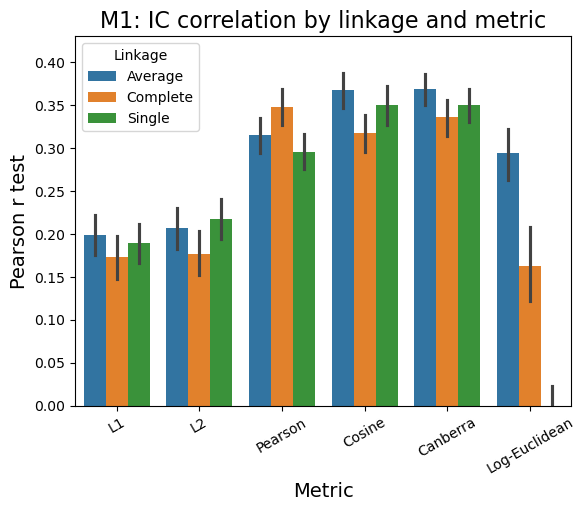

In [40]:
sns.barplot(data=grid_search_clustering_parameters
#             [grid_search_clustering_parameters['Channel'] == 'C1']
            ,
            y='Pearson r test', x = 'Metric', hue='Linkage', 
            order=['L1', 'L2', 'Pearson', 'Cosine', 'Canberra', 'Log-Euclidean']
           )
plt.ylim(0, 0.43)
plt.xticks(rotation=30)
plt.title('M1: IC correlation by linkage and metric')

In [41]:
print(grid_search_clustering_parameters[
    (grid_search_clustering_parameters['Metric'] == 'Log-Euclidean') &
    (grid_search_clustering_parameters['Linkage'] == 'Average')
]['Pearson r test'].mean())
grid_search_clustering_parameters[
    (grid_search_clustering_parameters['Metric'] == 'Log-Euclidean') &
    (grid_search_clustering_parameters['Linkage'] == 'Average')
]['Selected elements'].iloc[0]

0.29388106852778834


[5, 6, 7, 23, 24, 26, 27, 41, 42, 43]

Text(0.5, 1.0, 'M1: Within-cluster correlation')

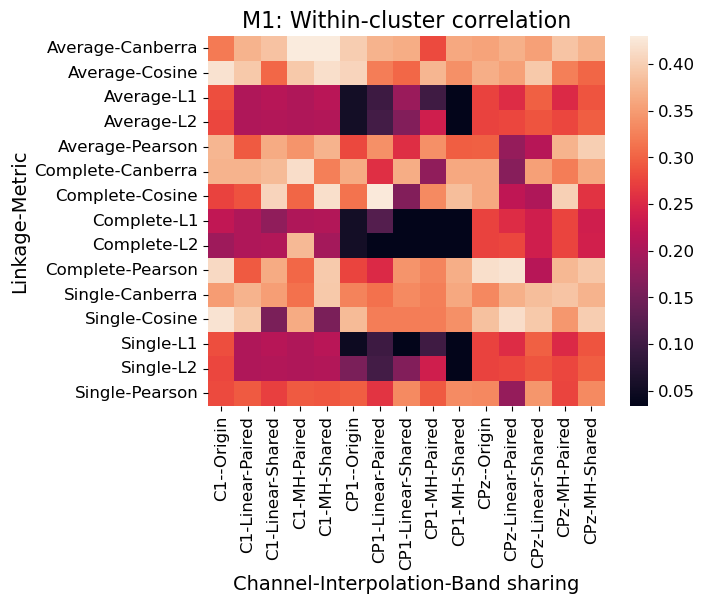

In [42]:
plt.rcParams.update({
    'axes.titlesize': 16,    # Title
    'axes.labelsize': 14,    # Axis labels
    'xtick.labelsize': 12,   # X-axis ticks
    'ytick.labelsize': 12,   # Y-axis ticks
    'legend.fontsize': 12    # Legend
})

test_copy = grid_search_clustering_parameters.copy()
test_copy = test_copy[test_copy['Interpolation'] != 'Matrices']
test_copy.loc[test_copy['Band sharing'] == 'Origin', 'Interpolation'] = ''
pivot_df = test_copy.pivot_table(
    index=['Linkage', 'Metric'],
    columns=['Channel', 'Interpolation', 'Band sharing'],
    values='Pearson r test'
)

# Drop 'mh' under 'from start'
pivot_df = pivot_df.drop(columns=[k for k in pivot_df.columns if 'Origin' in k and 'mh' in k])

# Rename 'interp' to ''
pivot_df = pivot_df.rename({
    ('Origin', 'Interp', 'Fp2'): ('Origin', '', 'Fp2')
}, axis='columns'
)
sns.heatmap(pivot_df)

plt.title('M1: Within-cluster correlation')
# CPz: from unibands, all, and individual, all
# C1 from individual, thresholded
# CP1 from unibands, thresholded
# FP2 from all other than unibands thresholded, spurious

In [43]:
grid_search_clustering_parameters[
    (grid_search_clustering_parameters['Linkage'] == 'Average') &
    (grid_search_clustering_parameters['Metric'] == 'Log-Euclidean')
]['Pearson r test'].mean()

np.float64(0.29388106852778834)

In [44]:
test_copy[
    (test_copy['Linkage'] == 'Average') &
    (test_copy['Metric'] == 'Canberra') &
    (test_copy['Interpolation'] == 'MH') &
    (test_copy['Band sharing'] == 'Shared') 
].iloc[0]

Linkage                                              Average
Metric                                              Canberra
N clusters                                                10
N selected                                                10
Channel                                                  CP1
Wcss                                             4498.285668
Selected elements    [5, 11, 12, 13, 21, 22, 28, 32, 38, 39]
Max min distance                                  339.934972
Interpolation                                             MH
Band sharing                                          Shared
Pearson r test                                      0.354064
Pearson p test                                           0.0
Mse test                                            0.897222
Nmse test                                           0.885954
R2 test                                             0.125173
Mse val                                             0.857484
R2 val                  

In [45]:
[f"{dataset[k]['subj']} - {dataset[k]['run']}" for k in [5, 6, 7, 11, 12, 28, 32, 34, 38, 39]]

['xp218 - 01',
 'xp218 - 02',
 'xp218 - 03',
 'xp222 - 03',
 'xp222 - 01',
 'xp221 - 02',
 'xp219 - 03',
 'xp219 - 02',
 'xp216 - 02',
 'xp216 - 03']

In [46]:
test_copy[
    (test_copy['Linkage'] == 'Average') &
    (test_copy['Metric'] == 'Pearson') &
    (test_copy['Interpolation'] == 'MH') &
    (test_copy['Band sharing'] == 'Shared') 
].pivot_table(
    index=['Channel'],
    columns=['Interpolation'],
    values='OOC pearson r',
)

Interpolation,MH
Channel,
C1,0.057994
CP1,-0.035508
CPz,0.141333


In [47]:
pivot_df

Channel                  C1                                               CP1  \
Interpolation                  Linear                  MH                       
Band sharing         Origin    Paired    Shared    Paired    Shared    Origin   
Linkage  Metric                                                                 
Average  Canberra  0.319603  0.372375  0.387403  0.430186  0.429969  0.398280   
         Cosine    0.419564  0.394527  0.303290  0.394527  0.417019  0.405883   
         L1        0.283509  0.205338  0.211876  0.205338  0.213419  0.053871   
         L2        0.277724  0.205338  0.208055  0.205338  0.208055  0.053871   
         Pearson   0.374841  0.292392  0.365037  0.342191  0.371811  0.278580   
Complete Canberra  0.371540  0.372375  0.379118  0.414921  0.324691  0.365109   
         Cosine    0.273973  0.287456  0.406217  0.301917  0.417019  0.313280   
         L1        0.221287  0.205338  0.176930  0.205338  0.208055  0.053871   
         L2        0.189820  0.205338  0.208055  0.377795  0.194990  0.053871   
         Pearson   0.411233  0.292392  0.365037  0.304693  0.395214  0.276259   
Single   Canberra  0.350146  0.371697  0.351352  0.311572  0.394044  0.327725   
         Cosine    0.421965  0.394527  0.157487  0.365047  0.157487  0.379576   
         L1        0.283509  0.205338  0.211876  0.205338  0.213419  0.047007   
         L2        0.277724  0.205338  0.208055  0.205338  0.208055  0.156558   
         Pearson   0.280135  0.292392  0.271217  0.292392  0.290352  0.295491   

Channel                                                         CPz            \
Interpolation        Linear                  MH                        Linear   
Band sharing         Paired    Shared    Paired    Shared    Origin    Paired   
Linkage  Metric                                                                 
Average  Canberra  0.372696  0.365814  0.280682  0.361114  0.357226  0.369222   
         Cosine    0.322020  0.303619  0.375280  0.339304  0.368209  0.354512   
         L1        0.098572  0.186397  0.099158  0.033704  0.274201  0.254775   
         L2        0.104450  0.163984  0.236760  0.033704  0.274201  0.278327   
         Pearson   0.338875  0.255477  0.338875  0.296428  0.297135  0.181157   
Complete Canberra  0.257656  0.365814  0.176756  0.361114  0.361398  0.169362   
         Cosine    0.428268  0.163823  0.333050  0.383152  0.362011  0.220466   
         L1        0.120930  0.033704  0.033704  0.033704  0.274201  0.254775   
         L2        0.033704  0.033704  0.033704  0.033704  0.274201  0.278327   
         Pearson   0.252036  0.342144  0.329162  0.367698  0.416510  0.421320   
Single   Canberra  0.312284  0.332952  0.324854  0.361114  0.332307  0.369222   
         Cosine    0.322020  0.322020  0.322020  0.339304  0.385699  0.415339   
         L1        0.098572  0.033704  0.099158  0.033704  0.274201  0.254775   
         L2        0.104450  0.163984  0.236760  0.033704  0.274201  0.278327   
         Pearson   0.262320  0.333787  0.292748  0.334663  0.332531  0.181157   

Channel                                          
Interpolation                      MH            
Band sharing         Shared    Paired    Shared  
Linkage  Metric                                  
Average  Canberra  0.354177  0.388821  0.372841  
         Cosine    0.394212  0.323643  0.302873  
         L1        0.297673  0.250559  0.288971  
         L2        0.288002  0.277144  0.296788  
         Pearson   0.211901  0.371669  0.399349  
Complete Canberra  0.354177  0.322789  0.361169  
         Cosine    0.204790  0.401191  0.260622  
         L1        0.238041  0.275456  0.238041  
         L2        0.238041  0.275456  0.239378  
         Pearson   0.211901  0.376397  0.391518  
Single   Canberra  0.382872  0.388821  0.372841  
         Cosine    0.394212  0.345387  0.398532  
         L1        0.297673  0.250559  0.288971  
         L2        0.288002  0.277144  0.296788  
         Pearson   0

np.float64(0.2276652758076207)

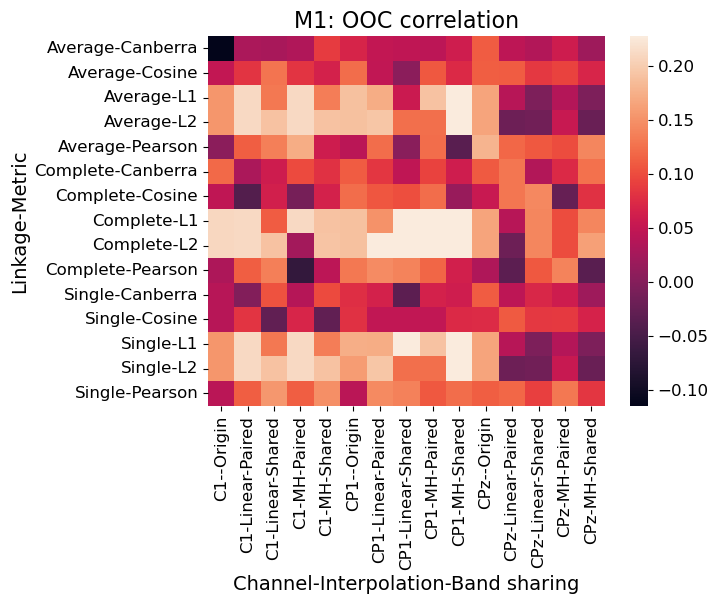

In [48]:
test_copy = grid_search_clustering_parameters.copy()
test_copy = test_copy[test_copy['Interpolation'] != 'Matrices']
test_copy.loc[
    (test_copy['Band sharing'] == 'Origin') &
    (test_copy['Interpolation'] == 'Linear'),
    'Interpolation'] = ''
pivot_df = test_copy.pivot_table(
    index=['Linkage', 'Metric'],
    columns=['Channel', 'Interpolation', 'Band sharing'],
    values='OOC pearson r'
)

# Drop 'mh' under 'from start'
pivot_df = pivot_df.drop(columns=[k for k in pivot_df.columns if 'Origin' in k and 'MH' in k])

# Rename 'interp' to ''
pivot_df = pivot_df.astype(float)
sns.heatmap(pivot_df)
plt.title('M1: OOC correlation')
np.array(pivot_df).max()
# CPz: from unibands, all, and individual, all
# C1 from individual, thresholded
# CP1 from unibands, thresholded
# FP2 from all other than unibands thresholded, spurious

In [49]:
best_ooc = np.array(grid_search_clustering_parameters[
    (grid_search_clustering_parameters['Metric'] == 'L2') &
    (grid_search_clustering_parameters['Linkage'] == 'Complete') &
    (grid_search_clustering_parameters['Channel'] == 'CP1') &
    (grid_search_clustering_parameters['Interpolation'] == 'MH') &
    (grid_search_clustering_parameters['Band sharing'] == 'Shared')
]['OOC pearson r'])
best_ic = np.array(grid_search_clustering_parameters[
    (grid_search_clustering_parameters['Metric'] == 'Canberra') &
    (grid_search_clustering_parameters['Linkage'] == 'Average') &
    (grid_search_clustering_parameters['Channel'] == 'C1') &
    (grid_search_clustering_parameters['Interpolation'] == 'MH') &
    (grid_search_clustering_parameters['Band sharing'] == 'Paired')
]['Pearson r test'])
cpz_pearson_ic = np.array(grid_search_clustering_parameters[
    (grid_search_clustering_parameters['Metric'] == 'Pearson') &
    (grid_search_clustering_parameters['Linkage'] == 'Average') &
    (grid_search_clustering_parameters['Channel'] == 'CP1') &
    (grid_search_clustering_parameters['Interpolation'] == 'MH') &
    (grid_search_clustering_parameters['Band sharing'] == 'Shared')
]['Pearson r test'])
cpz_pearson_ooc = np.array(grid_search_clustering_parameters[
    (grid_search_clustering_parameters['Metric'] == 'Pearson') &
    (grid_search_clustering_parameters['Linkage'] == 'Average') &
    (grid_search_clustering_parameters['Channel'] == 'CPz') &
    (grid_search_clustering_parameters['Interpolation'] == 'MH') &
    (grid_search_clustering_parameters['Band sharing'] == 'Shared')
]['OOC pearson r'])


Text(0.5, 1.0, 'M1: IC correlation, select clusters')

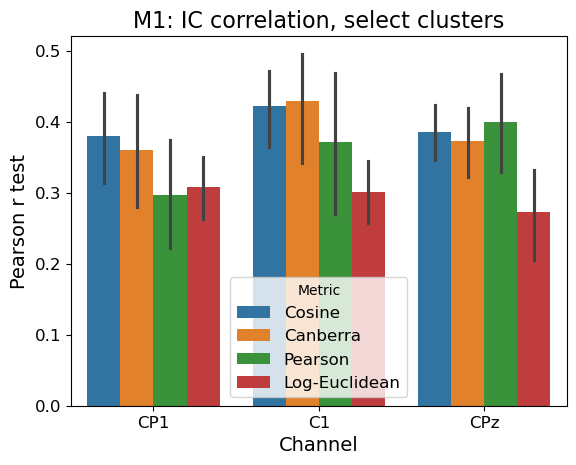

In [50]:
sns.barplot(data=pd.concat((grid_search_clustering_parameters[
    (grid_search_clustering_parameters['Metric'] == 'Cosine') &
    (grid_search_clustering_parameters['Linkage'] == 'Single') &
#     (grid_search_clustering_parameters['Channel'] == 'CP1') &
#     (grid_search_clustering_parameters['Interpolation'] == 'MH') &
    (grid_search_clustering_parameters['Band sharing'] == 'Origin')
],
                            grid_search_clustering_parameters[
    (grid_search_clustering_parameters['Metric'] == 'Canberra') &
    (grid_search_clustering_parameters['Linkage'] == 'Average') &
#     (grid_search_clustering_parameters['Channel'] == 'CP1') &
    (grid_search_clustering_parameters['Interpolation'] == 'MH') &
    (grid_search_clustering_parameters['Band sharing'] == 'Shared')
],
                                                        grid_search_clustering_parameters[
    (grid_search_clustering_parameters['Metric'] == 'Pearson') &
    (grid_search_clustering_parameters['Linkage'] == 'Average') &
#     (grid_search_clustering_parameters['Channel'] == 'CP1') &
    (grid_search_clustering_parameters['Interpolation'] == 'MH') &
    (grid_search_clustering_parameters['Band sharing'] == 'Shared')
],
                            
                                                        grid_search_clustering_parameters[
    (grid_search_clustering_parameters['Metric'] == 'Log-Euclidean') &
    (grid_search_clustering_parameters['Linkage'] == 'Average')
]
                            
                           )), y = 'Pearson r test', x='Channel', hue='Metric')

plt.title('M1: IC correlation, select clusters')